We want to create a spline $s(x)$ such that

$$
s(x) = 
\begin{cases}
s_0(x) &, &x \in [t_0, t_1) \\
s_1(x) &, &x \in [t_1, t_2) \\
&... \\
s_n(x) &, &x \in [t_{n-1}, t_n)
\end{cases}
$$

Given $h_i = t_{i+1} - t_i$, for each $s_i$, it is

$$
s_i(x) = \frac{z_{i+1}}{6h_i}(x - t_i)^3 + \frac{z_i}{6h_i}(t_{i+1} - x)^3 + (\frac{y_{i+1}}{h_i} - \frac{z_{i+1}h_i}{6})(x-t_i)+(\frac{y_i}{h_i} - \frac{z_ih_i}{6})(t_{i+1} - x)
$$

where $z_1, z_2, ..., z_{n-1}$ are calculated from the linear equation that

$$
\begin{align*}
\begin{bmatrix}
\frac{h_0 + h_1}{3} & \frac{h_1}{6} & 0 & 0 & ... & 0 & 0 & 0 \\
\frac{h_1}{6} & \frac{h_1 + h_2}{3} & \frac{h_2}{6} & 0 & ... & 0 & 0 & 0 \\
&...&...&&...&&...& \\
0 & 0 & 0 & 0 & ... & \frac{h_{n-3}}{6} & \frac{h_{n-3} + h_{n-2}}{3} & \frac{h_{n-2}}{6} \\
0 & 0 & 0 & 0 & ... & 0 & \frac{h_{n-2}}{6} &  \frac{h_{n-2} + h_{n-1}}{3}
\end{bmatrix}
\begin{bmatrix}
z_1 \\
z_2 \\
... \\
z_{n-2} \\
z_{n-1}
\end{bmatrix}
&=
\begin{bmatrix}
\frac{y_2-y_1}{h_1} - \frac{y_1-y_0}{h_0} \\
\frac{y_3-y_2}{h_2} - \frac{y_2-y_1}{h_1} \\
...\\
\frac{y_{n-1}-y_{n-2}}{h_{n-2}} - \frac{y_{n-2}-y_{n-3}}{h_{n-3}} \\
\frac{y_n-y_{n-1}}{h_{n-1}} - \frac{y_{n-1}-y_{n-2}}{h_{n-2}}
\end{bmatrix} \\
HZ &= Y \\
H^{-1} HZ &= H^{-1} Y \\
Z &= H^{-1} Y
\end{align*}
$$

and $z_0 = z_n = 0$

In [3]:
using LinearAlgebra

In [4]:
function calculateZ(Xs::Vector{Float64}, Ys::Vector{Float64}, n::Int64)::Vector{Float64}
    du::Vector{Float64} = []  # upper diag elements
    dd::Vector{Float64} = []
    dl::Vector{Float64} = []
    
    Y::Matrix{Float64} = zeros(Float64, n - 2, 1)
    
    # push elements into du dd dl
    # $h_i = t_{i+1} - t_i$
    for i in 1:n-2
        if i > 1
            h = Xs[i] - Xs[i - 1]
            push!(dl, h / 6.0)
        end
        if i < n - 2
            h = Xs[i + 2] - Xs[i + 1]
            push!(du, h / 6.0)
        end
        h1_h2 = Xs[i + 2] - Xs[i]
        push!(dd, h1_h2 / 3.0)
        
        Y[i, 1] = (Ys[i + 2] - Ys[i + 1]) / (Xs[i + 2] - Xs[i + 1]) - (Ys[i + 1] - Ys[i]) / (Xs[i + 1] - Xs[i])
    end
    
    # build H
    H::Tridiagonal{Float64, Vector{Float64}} = Tridiagonal(dl, dd, du)
    
    # calculate Z
    Zmat::Matrix{Float64} = inv(H) * Y
    Z::Vector{Float64} = vec(Zmat)
    
    push!(Z, 0.0)
    pushfirst!(Z, 0.0)
    
    return Z
end

calculateZ (generic function with 1 method)

In [5]:
function splineInterpolation(data::Dict{Float64, Float64}, x::Float64)::Float64
    # determine which interval x is in
    Xs::Vector{Float64} = sort(collect(keys(data)))
    Ys::Vector{Float64} = [data[i] for i in Xs]
    n::Int64 = length(Xs)
    
    Z::Vector{Float64} = calculateZ(Xs, Ys, n)
    
    for i in 1:n-1
        if (i == 1 && x < Xs[i]) || Xs[i] <= x < Xs[i + 1] || (i == n - 1 && x >= Xs[i])
            h = Xs[i + 1] - Xs[i]
            return Z[i + 1] / 6.0 / h * (x - Xs[i])^3.0 + Z[i] / 6.0 / h * (Xs[i + 1] - x)^3 + (Ys[i + 1] / h - (Z[i + 1] * h) / 6.0) * (x - Xs[i]) + (Ys[i] / h - Z[i] * h / 6.0) * (Xs[i + 1] - x)
        end
    end
    
    return Nothing
end

splineInterpolation (generic function with 1 method)

Test

In [6]:
mySample::Dict{Float64, Float64} = Dict(
    0.0 => -2.0,
    1.0 => 2.0,
    2.0 => -1.0,
    3.0 => 1.0,
    4.0 => 0.0,
)

Dict{Float64, Float64} with 5 entries:
  0.0 => -2.0
  4.0 => 0.0
  2.0 => -1.0
  3.0 => 1.0
  1.0 => 2.0

In [7]:
using Plots

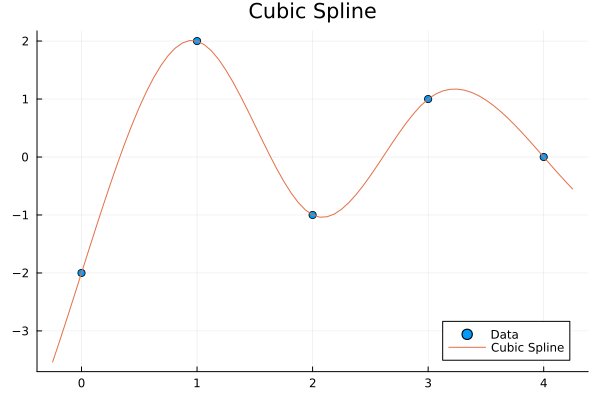

In [8]:
Xreal = collect(keys(mySample))
Yreal = [mySample[x] for x in Xreal]

Xhat = -0.25:0.0625:4.25
Yhat = [splineInterpolation(mySample, x) for x in Xhat]

scatter(Xreal, Yreal, title="Cubic Spline", label="Data")
plot!(Xhat, Yhat, label="Cubic Spline")

Test on more complex data

Try to manipulate $f(x)$, defined as

$$
f(x) = x + e^x + \frac{10}{1 + x^2} - 5
$$

within $x \in [-2, 2]$.

In [9]:
function f(x)
    return x .+ ℯ.^x .+ 10.0 ./ (1.0 .+ x.^2.0) .- 5.0
end

f (generic function with 1 method)

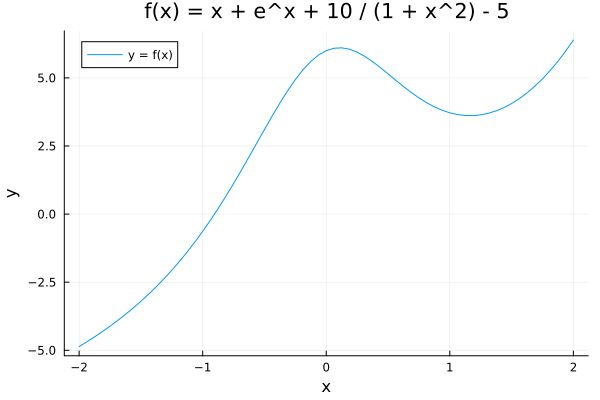

In [10]:
Xs = -2.0:0.0625:2.0
Ys = f(Xs)

plot(Xs, Ys, title="f(x) = x + e^x + 10 / (1 + x^2) - 5", label="y = f(x)", xlabel="x", ylabel="y")

Select 3 random points in $f(x)$

In [16]:
sampleFx_x = [0.1082036258342, 1.163398854061, -0.904562561256]
sampleFx_y = f(sampleFx_x)

3-element Vector{Float64}:
 6.1067529118151835
 3.613189167020513
 2.1192442645201481e-7

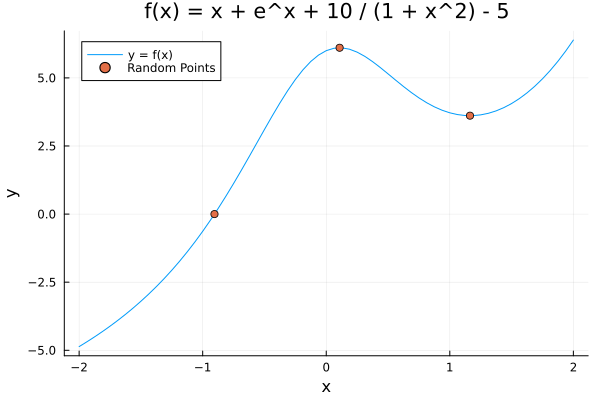

In [17]:
plot(Xs, Ys, title="f(x) = x + e^x + 10 / (1 + x^2) - 5", label="y = f(x)", xlabel="x", ylabel="y")
scatter!(sampleFx_x, sampleFx_y, label="Random Points")

Using our defined spline interpolator to interpolate the random points.

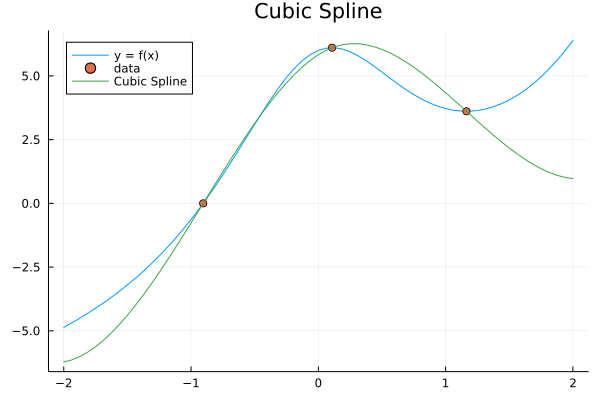

In [18]:
Xreal = -2.0:0.0625:2.0
Yreal = f(Xreal)

Xhat = -2.0:0.0625:2.0
Yhat = [splineInterpolation(Dict(x => y for (x, y) in zip(sampleFx_x, sampleFx_y)), x) for x in Xhat]

plot(Xreal, Yreal, title="Cubic Spline", label="y = f(x)")
scatter!(sampleFx_x, sampleFx_y, label="data")
plot!(Xhat, Yhat, label="Cubic Spline")